### Welcome to the Colab Spark Tutorial.

We will be using Spark a few times in this course, and the _colab_ environment provides the compute (for 12 hours at a time) we need, along with this wonderful web-based notebook.

Today we will be configuring PySpark and exploring the SparkSQL features in relation to the Spark API

Source material includes [[1](https://opensource.com/article/19/3/apache-spark-and-dataframes-tutorial)]

Sections:

 1. Configuring your _colab_
 2. Using PySpark


Firstly, we need to configure the _colab_ instance

In [3]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.3 LTS
Release:	18.04
Codename:	bionic


In [4]:
!apt-get update

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-ba

In [ ]:
# Install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null


In [23]:
# get spark 
!wget https://downloads.apache.org/spark/spark-3.0.0/spark-3.0.0-bin-hadoop2.7.tgz

--2020-08-15 20:04:23--  https://downloads.apache.org/spark/spark-3.0.0/spark-3.0.0-bin-hadoop2.7.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.95.219, 2a01:4f8:10a:201a::2
Connecting to downloads.apache.org (downloads.apache.org)|88.99.95.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 220272364 (210M) [application/x-gzip]
Saving to: ‘spark-3.0.0-bin-hadoop2.7.tgz’

spark-3.0.0-bin-had 100%[===================>] 210.07M  26.5MB/s    in 8.6s    

2020-08-15 20:04:32 (24.5 MB/s) - ‘spark-3.0.0-bin-hadoop2.7.tgz’ saved [220272364/220272364]



In [24]:
# decompress spark
!tar xf spark-3.0.0-bin-hadoop2.7.tgz

# install python package to help with system paths
!pip install -q findspark

In [29]:
# Let Colab know where the java and spark folders are

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop2.7"

In [31]:
# add pyspark to sys.path using findspark
import findspark
findspark.init()

# get a spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [33]:
spark

Let's download some url data ("Anonymized 120-day subset of the ICML-09 URL data containing 2.4 million examples and 3.2 million features" [UCI](https://archive.ics.uci.edu/ml/datasets/URL+Reputation)

In [56]:
! wget http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz
! wget http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names

--2020-08-15 21:18:52--  http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz
Resolving kdd.ics.uci.edu (kdd.ics.uci.edu)... 128.195.1.86
Connecting to kdd.ics.uci.edu (kdd.ics.uci.edu)|128.195.1.86|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2144903 (2.0M) [application/x-gzip]
Saving to: ‘kddcup.data_10_percent.gz’

kddcup.data_10_perc 100%[===================>]   2.04M  4.46MB/s    in 0.5s    

2020-08-15 21:18:52 (4.46 MB/s) - ‘kddcup.data_10_percent.gz’ saved [2144903/2144903]

--2020-08-15 21:18:55--  http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
Resolving kdd.ics.uci.edu (kdd.ics.uci.edu)... 128.195.1.86
Connecting to kdd.ics.uci.edu (kdd.ics.uci.edu)|128.195.1.86|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1307 (1.3K)
Saving to: ‘kddcup.names’

kddcup.names        100%[===================>]   1.28K  --.-KB/s    in 0s      

2020-08-15 21:18:55 (171 MB/s) - ‘kddcup.names’ saved [1307/1307]



In [49]:
!gunzip kddcup.data_10_percent.gz

In [64]:
import pandas as pd
df = pd.read_csv('kddcup.data_10_percent', header=None)

In [67]:
df[2].value_counts()

ecr_i      281400
private    110893
http        64293
smtp         9723
other        7237
            ...  
X11            11
tim_i           7
pm_dump         1
tftp_u          1
red_i           1
Name: 2, Length: 66, dtype: int64

In [71]:
raw_rdd = spark.sparkContext.textFile('kddcup.data_10_percent.gz').cache()
raw_rdd.take(5)

['0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,19,19,1.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,29,29,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,39,39,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,49,49,1.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,normal.']

In [72]:
csv_rdd = raw_rdd.map(lambda row: row.split(","))
print(csv_rdd.take(2))
print(type(csv_rdd))

[['0', 'tcp', 'http', 'SF', '181', '5450', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '8', '8', '0.00', '0.00', '0.00', '0.00', '1.00', '0.00', '0.00', '9', '9', '1.00', '0.00', '0.11', '0.00', '0.00', '0.00', '0.00', '0.00', 'normal.'], ['0', 'tcp', 'http', 'SF', '239', '486', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '8', '8', '0.00', '0.00', '0.00', '0.00', '1.00', '0.00', '0.00', '19', '19', '1.00', '0.00', '0.05', '0.00', '0.00', '0.00', '0.00', '0.00', 'normal.']]
<class 'pyspark.rdd.PipelinedRDD'>


In [75]:
from pyspark.sql import Row

parsed_rdd = csv_rdd.map(lambda r: Row(
    duration=int(r[0]),
    protocol_type=r[1],
    service=r[2],
    flag=r[3],
    src_bytes=int(r[4]),
    dst_bytes=int(r[5]),
    wrong_fragment=int(r[7]),
    urgent=int(r[8]),
    hot=int(r[9]),
    num_failed_logins=int(r[10]),
    num_compromised=int(r[12]),
    su_attempted=r[14],
    num_root=int(r[15]),
    num_file_creations=int(r[16]),
    label=r[-1]
    )
)
parsed_rdd.take(5)

[Row(duration=0, protocol_type='tcp', service='http', flag='SF', src_bytes=181, dst_bytes=5450, wrong_fragment=0, urgent=0, hot=0, num_failed_logins=0, num_compromised=0, su_attempted='0', num_root=0, num_file_creations=0, label='normal.'),
 Row(duration=0, protocol_type='tcp', service='http', flag='SF', src_bytes=239, dst_bytes=486, wrong_fragment=0, urgent=0, hot=0, num_failed_logins=0, num_compromised=0, su_attempted='0', num_root=0, num_file_creations=0, label='normal.'),
 Row(duration=0, protocol_type='tcp', service='http', flag='SF', src_bytes=235, dst_bytes=1337, wrong_fragment=0, urgent=0, hot=0, num_failed_logins=0, num_compromised=0, su_attempted='0', num_root=0, num_file_creations=0, label='normal.'),
 Row(duration=0, protocol_type='tcp', service='http', flag='SF', src_bytes=219, dst_bytes=1337, wrong_fragment=0, urgent=0, hot=0, num_failed_logins=0, num_compromised=0, su_attempted='0', num_root=0, num_file_creations=0, label='normal.'),
 Row(duration=0, protocol_type='tcp',

In [78]:
df = spark.createDataFrame(parsed_rdd)
df.show()

+--------+-------------+-------+----+---------+---------+--------------+------+---+-----------------+---------------+------------+--------+------------------+-------+
|duration|protocol_type|service|flag|src_bytes|dst_bytes|wrong_fragment|urgent|hot|num_failed_logins|num_compromised|su_attempted|num_root|num_file_creations|  label|
+--------+-------------+-------+----+---------+---------+--------------+------+---+-----------------+---------------+------------+--------+------------------+-------+
|       0|          tcp|   http|  SF|      181|     5450|             0|     0|  0|                0|              0|           0|       0|                 0|normal.|
|       0|          tcp|   http|  SF|      239|      486|             0|     0|  0|                0|              0|           0|       0|                 0|normal.|
|       0|          tcp|   http|  SF|      235|     1337|             0|     0|  0|                0|              0|           0|       0|                 0|normal.

In [79]:
help(df.registerTempTable)

Help on method registerTempTable in module pyspark.sql.dataframe:

registerTempTable(name) method of pyspark.sql.dataframe.DataFrame instance
    Registers this DataFrame as a temporary table using the given name.
    
    The lifetime of this temporary table is tied to the :class:`SparkSession`
    that was used to create this :class:`DataFrame`.
    
    >>> df.registerTempTable("people")
    >>> df2 = spark.sql("select * from people")
    >>> sorted(df.collect()) == sorted(df2.collect())
    True
    >>> spark.catalog.dropTempView("people")
    
    .. note:: Deprecated in 2.0, use createOrReplaceTempView instead.
    
    .. versionadded:: 1.3



In [80]:
df.registerTempTable('data')

In [85]:
df.groupBy('protocol_type').count().orderBy('count', ascending=False).collect()

[Row(protocol_type='icmp', count=283602),
 Row(protocol_type='tcp', count=190065),
 Row(protocol_type='udp', count=20354)]

In [88]:
protocols = spark.sql("""
      SELECT protocol_type, count(*) as freq
      FROM data
      GROUP BY protocol_type
      ORDER BY 2 DESC
                           """)
protocols.show()

+-------------+------+
|protocol_type|  freq|
+-------------+------+
|         icmp|283602|
|          tcp|190065|
|          udp| 20354|
+-------------+------+



In [89]:
df.count()

494021

In [90]:
df.rdd.getNumPartitions()


1

In [92]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

In [95]:
labels = spark.sql("""
                           SELECT label, count(*) as freq
                           FROM data
                           GROUP BY label
                           ORDER BY 2 DESC
                           """)

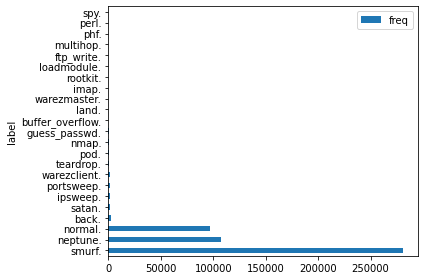

In [97]:
import matplotlib.pyplot as plt

labels_df = pd.DataFrame(labels.toPandas())
labels_df.set_index("label", drop=True,inplace=True)
labels_fig = labels_df.plot(kind='barh')

plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams.update({'font.size': 10})
plt.tight_layout()

In [101]:
attack_protocol = spark.sql("""
                           SELECT
                             protocol_type,
                             CASE label
                               WHEN 'normal.' THEN 'no attack'
                               ELSE 'attack'
                             END AS state,
                             COUNT(*) as freq
                           FROM data
                           GROUP BY protocol_type, state
                           ORDER BY 3 DESC
                           """)